# 1. Autoregressive Models
a. Write out the chain rule for a distribution over $x_1, x_2,...,x_n$.

$$ p(X)=p(x_1) * p(x_2 | x_1) * ... * p(x_n | x_{n-1}, x_{n-2},...,x_1) $$

b. Draw an example of a Masked Autoregressive Distribution Estimation (MADE) model and illustrate the key characteristic that qualify it as proper probability model.

<img src="hw1q1.png" width="200" style="background-color:white">

With MADE, the order of the inputs are fixed, leading to a product of conditional probabilities:

$$ p(X)=p(x_1) * p(x_3 | x_1) * p(x_2 | x_1, x_3) $$

# 2. KL-Divergence
Let $\mu:\chi\rightarrow\mathbb{R}^k, \sigma, \chi\rightarrow\mathbb{R}^k$ and $q(z|x)=N(z;\mu(x),\textnormal{diag}(\sigma^2(x)))$. Suppose that $p(z)=N(z;0,I)$, show that

$$D(q(z|x) || p(z)) = \frac{1}{2}\sum_i \sigma_i^2(x)+\mu(x)_i^2-\log\sigma_i^2(x)-1$$

---

Kullback-Leibler Divergence is Cross Entropy minus Entropy:

$$D(q(z|x) || p(z)) = H(q,p) - H(q)$$

---

Find Cross Entropy:

$$ H(q,p)=-\int q(z)\log p(z)dz $$

$$ p(z)=(2\pi)^{-\frac{1}{2}}\exp(-\frac{1}{2}z^2) $$

$$ H(q,p)=-\int q(z)\log [(2\pi)^{-\frac{1}{2}}\exp(-\frac{1}{2}z^2)]dz $$

$$ H(q,p)=\frac{1}{2}\log2\pi\int q(z)dz + \frac{1}{2}\int z^2q(z)dz$$

$$ H(q,p)=\frac{1}{2}[\log2\pi+\mu^2+\sigma^2] $$

where $ \int q(z)dz=1$ and $ \int z^2q(z)dz=\mu^2+\sigma^2 $ 

---

Find Entropy:

$$ H(q)=-\int q(z)\log q(z)dz $$

$$ H(q)=-\int q(z)\log [(2\pi\sigma^2)^{-\frac{1}{2}}\exp(-\frac{1}{2\sigma^2}(z-\mu)^2)]dz $$

$$ H(q)=\frac{1}{2}\log2\pi\int q(z)dz+\frac{1}{2}\int(\frac{z-\mu}{\sigma^2})^2q(z)dz $$

$$ H(q)=\frac{1}{2}[\log 2\pi+\log \sigma^2 + 1]$$

where $ \int(\frac{z-\mu}{\sigma^2})^2q(z)dz=1 $

---

Solve for KL Divergence for each dimension:

$$D(q(z|x) || p(z))=\frac{1}{2}[\log2\pi+\mu^2+\sigma^2]-\frac{1}{2}[\log 2\pi+\log \sigma^2 + 1] $$

$$ D(q(z|x) || p(z))=\frac{1}{2}[\sigma^2+\mu^2-\log\sigma^2-1] $$

Generalize for multiple dimensions:

$$ D(q(z|x) || p(z))=\sum_{i=1}^{k}\frac{1}{2}[\sigma_i^2+\mu_i^2-\log\sigma_i^2-1] $$

# 3. Normalizing Flows
Let $q_0$ be a probability distribution on $z$, and define $\mathbf{z}_s=g_s(\mathbf{z}_{t-1})$ where $g_s:z\rightarrow z$ are invertible functions. Prove that the pushforward distribution on $\mathbf{z}_t=g_t \circ ... \circ g_1(\mathbf{z}_0)$ is given by $q_t$, where
$$ \log q_t(\mathbf{z}_t)=\log q_0(z_0)-\sum_{s=1}^t\log\det\frac{\partial g_s(\mathbf{z}_{s-1})}{\partial\mathbf{z}_{s-1}} $$
Hint: consider using the inverse function theorem.

# 4. Variational Autoencoders
In this question, you will train a VAE model on the MNIST dataset. This dataset conssits of 28x28 grayscale images. Please implement a standard VAE with the following characteristics:

a. 16-dim latent variables $z$ with standard normal prior $p(z)=N(0,I)$

b. An approximate posterior $q_\theta(z|x)=N(z;\mu_\theta(x),I)$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix.

c. A decoder $p(x|z)=N(x;\mu_\phi(z),I)$, where $\mu_\phi(z)$ is the mean vector (We are not learning the covariance of the decoder).

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import numpy as np
import torch
from torch import nn
import pickle
import matplotlib.pyplot as plt
import einops


In [19]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, pkl='mnist.pkl', phase='train'):
        with open(pkl, 'rb') as f:
            mnist = pickle.load(f)
        self.img = mnist[phase]
        self.img = torch.tensor(np.expand_dims(self.img.squeeze(-1), 1))
        self.label = torch.tensor(mnist[f'{phase}_labels'])

    def __len__(self):
        return self.label.shape[0]
    
    def __getitem__(self, ndx):
        # img = self.img[ndx] / 255.
        img = self.img[ndx].float()
        label = self.label[ndx]
        return img, label

In [36]:
latent.shape

torch.Size([10, 10, 16])

In [20]:
class VAE(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(), # 14 x 14
            nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(), # 7 x 7
            nn.Conv2d(128, 256, 3, 2, 1), nn.ReLU(), # 4 x 4
            nn.Flatten(),
            nn.Linear(4 * 4 * 256, latent_dim), 
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 4 * 4 * 256), nn.ReLU(),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, 3, 2, 1), nn.ReLU(), # 7 x 7
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(), # 14 x 14
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),  # 28 x 28
            nn.Conv2d(32, 1, 3, 1, 1), 
            # nn.Sigmoid(),
        )

    def forward(self, x):
        latent = self.encoder(x)
        out = self.decoder(latent)
        return out, latent

In [21]:
n_epochs=100
batch_size = 128
lr = 1e-3
device = 'cuda:0'
# recon_loss_fn = torch.nn.MSELoss()

def mse_loss_fn(input, target):
    return ((target - input) ** 2).mean()
def kl_loss_fn(input):
    std = input.std(axis=0)
    mean = input.mean(axis=0)
    return 0.5 * (std ** 2 + mean ** 2 - (std ** 2).log() - 1).sum()

model = VAE().to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr)

In [22]:
ds_train = MNISTDataset(phase='train')
ds_test = MNISTDataset(phase='test')
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, shuffle=False)

In [23]:
train_loss = []
test_loss = []

for epoch_ndx in range(1, n_epochs+1):
    train_batch_loss = {'kl':[], 'mse':[]}
    model.train()
    for batch in dl_train:
        x, label = batch
        x = x.to(device)
        label = label.to(device)

        optim.zero_grad()
        x_pred, latent = model(x)
        mse_loss = mse_loss_fn(x_pred, x)
        kl_loss = kl_loss_fn(latent)
        loss = mse_loss + kl_loss
        loss.backward()
        optim.step()

        train_batch_loss['kl'].append(kl_loss.detach().cpu())
        train_batch_loss['mse'].append(mse_loss.detach().cpu())
    train_loss.append(train_batch_loss)

    test_batch_loss = {'kl':[], 'mse':[]}
    model.eval()
    with torch.no_grad():
        for batch in dl_test:
            x, label = batch
            x = x.to(device)
            label = label.to(device)

            x_pred, latent = model(x)
            mse_loss = mse_loss_fn(x_pred, x)
            kl_loss = kl_loss_fn(latent)
            loss = mse_loss + kl_loss

            test_batch_loss['kl'].append(kl_loss.detach().cpu())
            test_batch_loss['mse'].append(mse_loss.detach().cpu())
        test_loss.append(test_batch_loss)
    msg = f"E{epoch_ndx: 4d} | "
    msg += f"TRAIN | KL:{np.array(train_batch_loss['kl']).mean():4.4f} | MSE: {np.array(train_batch_loss['mse']).mean():4.4f} | "
    msg += f" TEST | KL:{np.array(test_batch_loss['kl']).mean():4.4f} | MSE: {np.array(test_batch_loss['mse']).mean():4.4f}"
    print(msg)

E   1 | TRAIN | KL:33.4490 | MSE: 2010.0920 |  TEST | KL:19.6005 | MSE: 898.5327
E   2 | TRAIN | KL:13.8772 | MSE: 807.5010 |  TEST | KL:11.6600 | MSE: 706.2784
E   3 | TRAIN | KL:9.3134 | MSE: 679.7200 |  TEST | KL:8.6264 | MSE: 624.3696
E   4 | TRAIN | KL:7.2810 | MSE: 606.9202 |  TEST | KL:6.1267 | MSE: 598.7456
E   5 | TRAIN | KL:5.9654 | MSE: 566.7297 |  TEST | KL:6.1756 | MSE: 557.4835
E   6 | TRAIN | KL:5.1075 | MSE: 536.3784 |  TEST | KL:5.4739 | MSE: 524.7924
E   7 | TRAIN | KL:4.4858 | MSE: 513.5252 |  TEST | KL:4.7668 | MSE: 505.4476
E   8 | TRAIN | KL:4.0016 | MSE: 495.5627 |  TEST | KL:4.0721 | MSE: 492.6656
E   9 | TRAIN | KL:3.6393 | MSE: 479.5955 |  TEST | KL:4.1002 | MSE: 491.9792
E  10 | TRAIN | KL:3.3319 | MSE: 464.5184 |  TEST | KL:3.5074 | MSE: 472.4503
E  11 | TRAIN | KL:3.0664 | MSE: 455.5842 |  TEST | KL:3.5342 | MSE: 460.8997
E  12 | TRAIN | KL:2.8478 | MSE: 441.6773 |  TEST | KL:3.1020 | MSE: 455.5299
E  13 | TRAIN | KL:2.6398 | MSE: 432.6255 |  TEST | KL:2.93

## Request deliverables
a. Record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.

In [24]:
msg = f"Training losses @ epoch {n_epochs}: "
msg += f"ELBO: {(np.array(train_loss[-1]['mse']) + np.array(train_loss[-1]['kl'])).mean():4.4f} "
msg += f"MSE: {np.array(train_loss[-1]['mse']).mean():4.4f} "
msg += f"KLD: {np.array(train_loss[-1]['kl']).mean():4.4f} "
print(msg)

Training losses @ epoch 100: ELBO: 264.9209 MSE: 264.4359 KLD: 0.4849 


In [25]:
model.eval()
x_pred = []
latent = []
with torch.no_grad():
    for batch in dl_test:
        x, label = batch
        x = x.to(device)
        label = label.to(device)

        x_pred_batch, latent_batch = model(x)
        x_pred.append(x_pred_batch)
        latent.append(latent_batch)

x = ds_test.img.to(device)
x_pred = torch.concat(x_pred)
latent = torch.concat(latent)
mse_loss = mse_loss_fn(x_pred, x)
kl_loss = kl_loss_fn(latent)
loss = mse_loss + kl_loss

In [26]:
msg = f"Testing losses @ epoch {n_epochs}: "
msg += f"ELBO: {mse_loss.item() + kl_loss.item():4.4f} "
msg += f"MSE: {mse_loss:4.4f} "
msg += f"KLD: {kl_loss:4.4f} "
print(msg)

Testing losses @ epoch 100: ELBO: 356.0655 MSE: 355.6954 KLD: 0.3701 


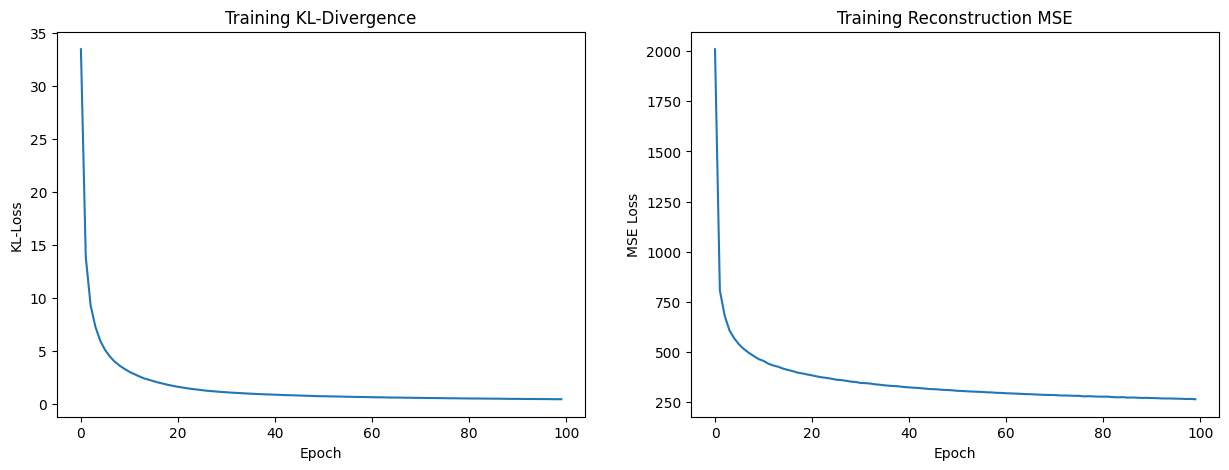

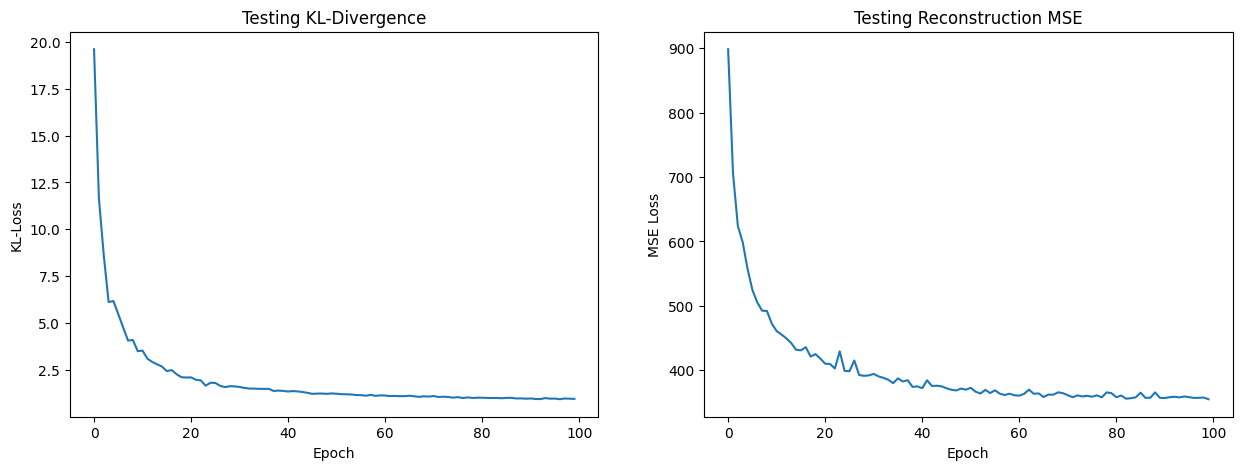

In [27]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].plot(range(len(train_loss)), [np.array(l['kl']).mean() for l in train_loss])
ax[0].set_title('Training KL-Divergence')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('KL-Loss')
ax[1].plot(range(len(train_loss)), [np.array(l['mse']).mean() for l in train_loss])
ax[1].set_title('Training Reconstruction MSE')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('MSE Loss')
plt.show()
fig, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].plot(range(len(test_loss)), [np.array(l['kl']).mean() for l in test_loss])
ax[0].set_title('Testing KL-Divergence')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('KL-Loss')
ax[1].plot(range(len(test_loss)), [np.array(l['mse']).mean() for l in test_loss])
ax[1].set_title('Testing Reconstruction MSE')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('MSE Loss')
plt.show()

b. Report the final test set performance of your final model.

In [28]:
msg = f"Testing losses @ epoch {n_epochs}: "
msg += f"ELBO: {mse_loss.item() + kl_loss.item():4.4f} "
msg += f"MSE: {mse_loss:4.4f} "
msg += f"KLD: {kl_loss:4.4f} "
print(msg)

Testing losses @ epoch 100: ELBO: 356.0655 MSE: 355.6954 KLD: 0.3701 


c. 100 samples from your trained VAE (put all sample in one figure).

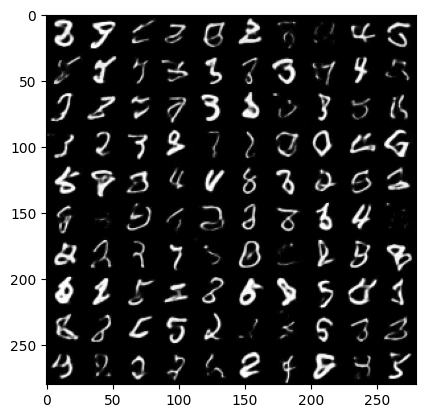

In [34]:
noise = torch.normal(mean=torch.zeros((100, 16)), std=torch.ones((100, 16))).to(device)
model.eval()
with torch.no_grad():
    x_pred = model.decoder(noise).detach().cpu()
x_pred[x_pred < 0] = 0
x_pred[x_pred > 255] = 255

x_pred = einops.rearrange(x_pred, '(img_h img_w) () h w -> (img_h h) (img_w w)', img_h=10)
im = plt.imshow(x_pred, 'gray')
# plt.colorbar(im)
plt.show()

d. 50 real-image / reconstruction pairs (put all sample in one figure).

In [30]:
ds_test.label.unique(return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))

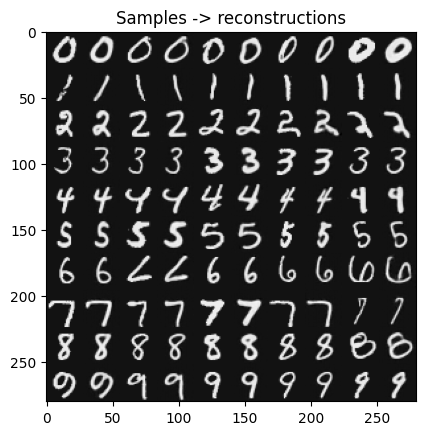

In [31]:
out = []
model.eval()
for label in range(10):
    indices = (ds_test.label == label).nonzero().squeeze(-1)
    indices = indices[torch.randperm(len(indices))[:5]]
    sample = ds_test.img[indices]
    with torch.no_grad():
        recon = model(sample.float().to(device))[0].cpu()
    out.append(torch.stack((sample, recon)))
out = torch.stack(out)
plt.imshow(einops.rearrange(out, 'd o s () h w -> (d h) (s o w)'), 'gray')
plt.title('Samples -> reconstructions')
plt.show()

e. Interpolations of length 10 between 10 pairs of test images from your VAE (100 images total)

Text(0.5, 1.0, 'Interpolating between random points in latent space')

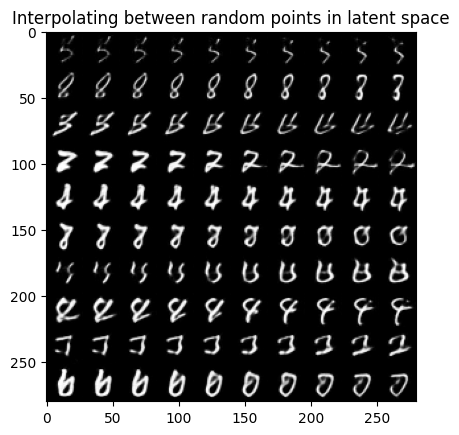

In [32]:
# noise = torch.normal(mean=torch.zeros((20, 16)), std=torch.ones((20, 16))).to(device)
# model.eval()
# with torch.no_grad():
#     x_pred = model.decoder(noise).detach().cpu()
# x_pred[x_pred < 0] = 0
# x_pred[x_pred > 255] = 255

# x_pred = einops.rearrange(x_pred, '(d1 d2) 1 h w -> d1 d2 1 h w', d1=2)
latent = torch.empty((10, 10, 16)).to(device)

latent[0] = torch.normal(mean=torch.zeros((10, 16)), std=torch.ones((10, 16)))
latent[-1] = torch.normal(mean=torch.zeros((10, 16)), std=torch.ones((10, 16)))
for i in range(1,10):
    latent[i] = torch.lerp(latent[0], latent[-1], i * 0.1)
latent.reshape((100, 16))

model.eval()
with torch.no_grad():
    x_pred = model.decoder(latent.reshape((100, 16))).detach().cpu()
x_pred[x_pred < 0] = 0
x_pred[x_pred > 255] = 255
x_pred = einops.rearrange(x_pred.reshape((10, 10, 28, 28)), 'img_h img_w h w -> (img_w h) (img_h w)')
plt.imshow(x_pred, 'gray')
plt.title('Interpolating between random points in latent space')


## Helpful Tips:
* When computing reconstruction loss and KL loss, average over the batch dimension and sum over the feature
dimension
* When computing reconstruction loss, it suffices to just compute MSE between the reconstructed and true
images. (you can compute the extra constants if you want)
* Use batch size $128$, learning rate $10^{-3}$, and an Adam optimizer
* You can play around with different architectures and try for better results, but the following encoder / decoder
architecture below suffices.


# 